# Example 2

This example reproduces a part of Figure 4 from Genkin et. al. 2024. We will load PMd recordings from the example population, optimize the model on this data, select the model and plot the results. 

## Step 1: Check PSTHs. Load the data and plot PSTH aligned to stimulus onset and sorted by chosen side and stimulus difficulty.

Data contains the following columns ['chosen_side', 'correct_response', 'stim_onset', 'RT', 'neuron_0', 'neuron_1', 'neuron_2', 'neuron_3', 'neuron_4', 'neuron_5', 'neuron_6', 'neuron_7', 'neuron_8', 'neuron_9', 'neuron_10', 'neuron_11', 'neuron_12', 'neuron_13', 'stim_difficulty']


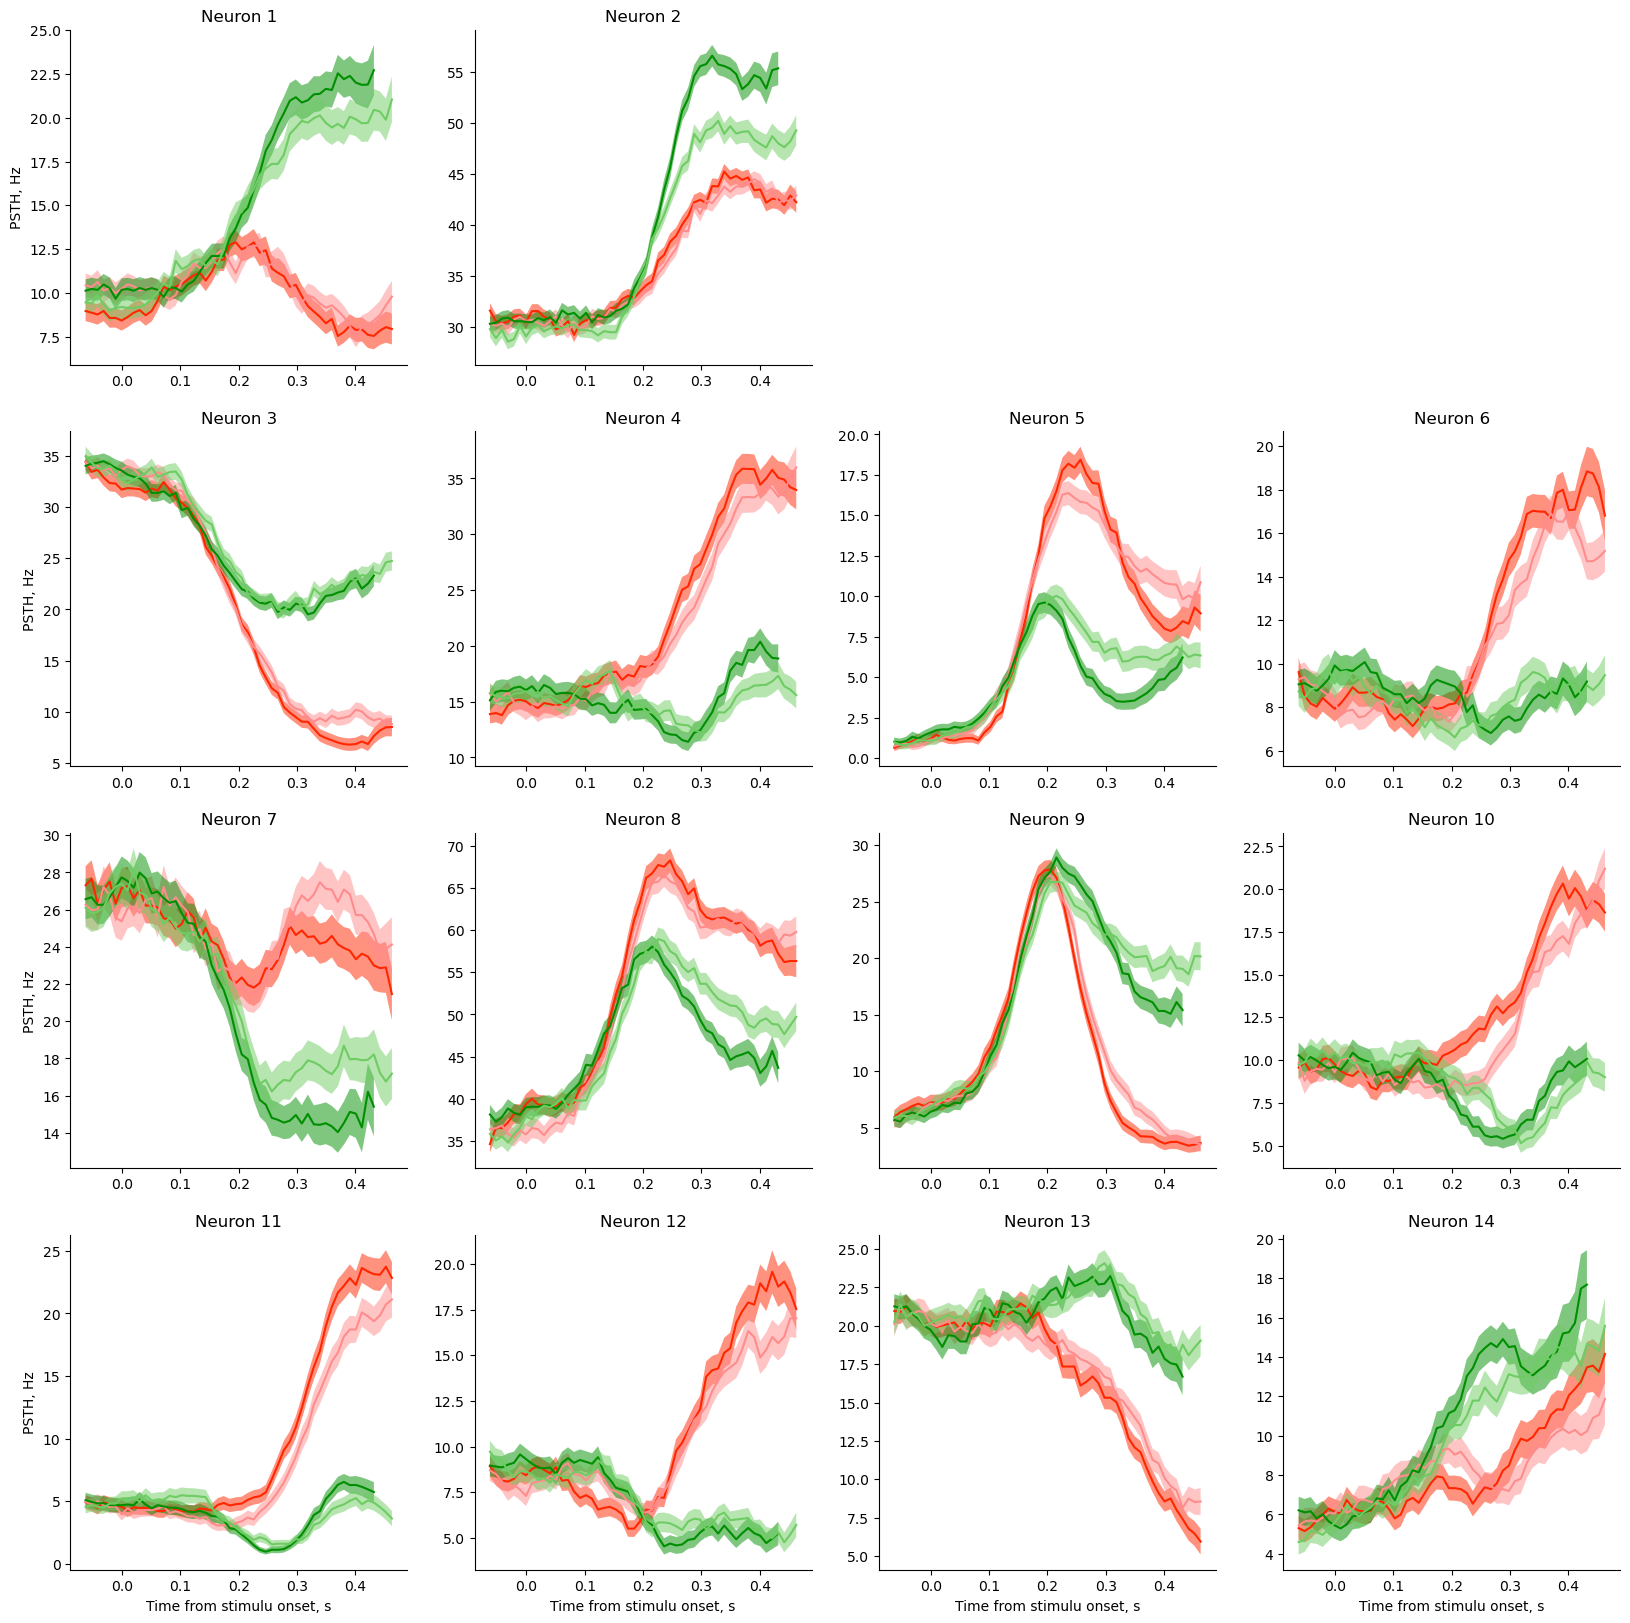

In [1]:
import os
import pickle
import zipfile
import pandas as pd
import numpy as np
import neuralflow
from neuralflow.utilities.psth import extract_psth
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# unzip the data
if 'population.pkl' not in os.listdir('data'):
    print('Exctracting zipped data')
    with zipfile.ZipFile('data/data_for_example.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

# read the data
with open('data/population.pkl', 'rb') as handle:
    data = pickle.load(handle)

print(f'Data contains the following columns {list(data.columns)}')
num_neurons = len([el for el in data.columns if el.startswith('neuron_')])

# Extract the data for visualization
data_spiketimes, RTs = {}, {}
for chosen_side in ['Left', 'Right']:
    for stim_difficulty in ['easy', 'hard']:
        # Filter data for the current condition
        data_cur = data[(data.chosen_side == chosen_side) & (data.stim_difficulty == stim_difficulty)]
        
        # Align to stimulus onset, consider time window from stimulus_onset-0.1 until RT 
        for u in range(num_neurons):
            data_cur.loc[:, f'neuron_{u}'] = data_cur[f'neuron_{u}'] - data_cur['stim_onset']
            data_cur.loc[:, f'neuron_{u}'] =  data_cur.apply(lambda x: x[f'neuron_{u}'][(x[f'neuron_{u}'] >= -0.1) & (x[f'neuron_{u}'] <= x.RT)], axis = 1)
            
        
        # Collect spikes into 2D array for each trial
        data_cur = data_cur.assign(spikes=data_cur[[f'neuron_{i}' for i in range(num_neurons)]].values.tolist())
        
        # Record reaction time and spikes
        RTs[f'{chosen_side}_{stim_difficulty}'] = data_cur['RT'].to_list()
        
        # Aggregate all spikes into num_neurons X num_trials array
        data_spiketimes[f'{chosen_side}_{stim_difficulty}'] = np.array([data_cur['spikes'].to_list()], dtype = object)[0].T
        
# Plot PSTH
time_window = 0.075 # bin size
dt = 0.01 # bin step
tbegin=-0.1 # start time for PSTH
tend=0.500 # End time for PSTH

color_lines = {
    'Left_hard': '#FF8C8C', 'Left_easy':  [1.0, 0.15, 0.0],
    'Right_hard': [0.43, 0.80, 0.39], 'Right_easy': [0.0, 0.56, 0.0]
    }

figure = plt.figure(figsize = (20, 20))
gs = gridspec.GridSpec(4,4)
for chosen_side in ['Left', 'Right']:
    for stim_difficulty in ['easy', 'hard']:
        tb, rates, rates_SEM = extract_psth(data_spiketimes[f'{chosen_side}_{stim_difficulty}'], RTs[f'{chosen_side}_{stim_difficulty}'], time_window, dt, tbegin, tend) 
        for i in range(14):
            subplot_num = i + 2 * int(i>=2)
            ax = plt.subplot(gs[subplot_num//4, subplot_num%4])
            spikes = rates[i]
            time = tb[0][:spikes.size]
            err = rates_SEM[i]
            plt.plot(time,spikes,'-', color=color_lines[f'{chosen_side}_{stim_difficulty}'])
            plt.fill_between(time, spikes-err, spikes+err, color=color_lines[f'{chosen_side}_{stim_difficulty}'],alpha=0.5,
                            edgecolor = "none")
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.title(f'Neuron {i+1}')
            if subplot_num // 4 == 3:
                plt.xlabel('Time from stimulu onset, s')
            if subplot_num % 4 ==0:
                plt.ylabel('PSTH, Hz')
    

## Step 2. Extract the data, split into two datasamples, and convert it into ISI format which can be used for model optimization.

In [2]:
# We analyze the data starting from 120 ms from stimulus onset. This accounts for the delay between stimulus onset
# and the emergence of decision-making dynamics in PMd.
time_offset = 0.12
datasample1, datasample2 = {}, {}
for stim_difficulty in ['hard', 'easy']:
    for chosen_side in ['Left', 'Right']:
        
        # Filter data for the current condition
        data_cur = data[(data.chosen_side == chosen_side) & (data.stim_difficulty == stim_difficulty)].reset_index()
        
        # Align to stimulus onset and subtract time offset. Set t=0 to 120 ms from stimulus onset, and stop at RT
        for u in range(num_neurons):
            data_cur.loc[:, f'neuron_{u}'] = data_cur[f'neuron_{u}'] - data_cur['stim_onset'] - time_offset
            data_cur.loc[:, f'neuron_{u}'] =  data_cur.apply(lambda x: x[f'neuron_{u}'][(x[f'neuron_{u}'] >= 0) & (x[f'neuron_{u}'] <= x.RT - time_offset)], axis = 1)
        
        # Collect spikes into 2D array for each trial
        data_cur = data_cur.assign(spikes=data_cur[[f'neuron_{i}' for i in range(num_neurons)]].values.tolist())
        
        # time epoch
        data_cur['time_epoch'] = data_cur.RT.apply(lambda x: (0, x - time_offset))
        
        # Assign even trials to datasample 1, and odd trials to datasample 2
        num_trials = data_cur.shape[0]
        
        ind1 = np.arange(0, num_trials, 2)
        datasample1[f'{chosen_side}_{stim_difficulty}'] = neuralflow.SpikeData(
            data = np.array(data_cur.loc[ind1,'spikes'].to_list(), dtype=np.ndarray).T, dformat = 'spiketimes', time_epoch = data_cur.loc[ind1, 'time_epoch'].to_list()
        )
        ind2 = np.arange(1, num_trials, 2)
        datasample2[f'{chosen_side}_{stim_difficulty}'] = neuralflow.SpikeData(
            data = np.array(data_cur.loc[ind2,'spikes'].to_list(), dtype=np.ndarray).T, dformat = 'spiketimes', time_epoch = data_cur.loc[ind2, 'time_epoch'].to_list()
        )
        
        # Convert to ISI format
        datasample1[f'{chosen_side}_{stim_difficulty}'].change_format('ISIs')
        datasample2[f'{chosen_side}_{stim_difficulty}'].change_format('ISIs')

## Step 3: Perform optimization. 

NOTE: population optimization may take a lot of time. To accelerate execution of the next cell, reduce "max_epoch" and/or make "epoch_schedule" in C_opt and D_opt empty

In [3]:
# The optimization was performed in a grid with Np = 8, Ne = 64. Here we set Ne to 16 to reduce fitting time
grid = neuralflow.GLLgrid(Np = 8, Ne = 16)

# Initial guess
init_model = neuralflow.model.new_model(
    peq_model = {"model": "uniform", "params": {}},
    p0_model = {"model": "cos_square", "params": {}},
    D = 1,
    fr_model = [{"model": "linear", "params": {"slope": 1, "bias": 100}}] * 14,
    params_size={'peq': 4, 'D': 1, 'fr': 1, 'p0': 1},
    grid = grid
)

optimizer = 'ADAM'

# In the paper we set max_epoch = 5000, mini_batch_number = 20, and did 30 line searches logarithmically scattered across 5000 epochs.
# Here we change these parameters to reduce optimization time
opt_params = {'max_epochs': 50, 'mini_batch_number': 20, 'params_to_opt': ['F', 'F0', 'D', 'Fr', 'C'], 'learning_rate': {'alpha': 0.05}}
ls_options = {'C_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 2}, 'D_opt': {'epoch_schedule': [0, 1, 5, 30], 'nSearchPerEpoch': 3, 'max_fun_eval': 25}}
boundary_mode = 'absorbing'

# Train on datasample 1
dataTR = [v for v in datasample1.values()]
optimization1 = neuralflow.optimization.Optimization(
                    dataTR,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                )

# run optimization
print('Running optimization on datasample 1')
optimization1.run_optimization()

# Train on datasample 2
dataTR = [v for v in datasample2.values()]
optimization2 = neuralflow.optimization.Optimization(
                    dataTR,
                    init_model,
                    optimizer,
                    opt_params,
                    ls_options,
                    boundary_mode=boundary_mode
                )

# run optimization
print('Running optimization on datasample 2')
optimization2.run_optimization()

Running optimization on datasample 1


100%|██████████| 50/50 [1:13:15<00:00, 87.90s/it]   


Running optimization on datasample 2


100%|██████████| 50/50 [1:10:15<00:00, 84.32s/it] 


## Step 4. Feature consistency analysis

In [4]:
from neuralflow.feature_complexity.fc_base import FC_tools

JS_thres = 0.0015
FC_stride = 5
smoothing_kernel = 10

fc = FC_tools(non_equilibrium=True, model=init_model, boundary_mode=boundary_mode, terminal_time=1)
FCs1, min_inds_1, FCs2, min_inds_2, JS, FC_opt_ind = (
    fc.FeatureConsistencyAnalysis(optimization1.results, optimization2.results, JS_thres, FC_stride, smoothing_kernel, epoch_offset = 4)
    )

invert = fc.NeedToReflect(optimization1.results, optimization2.results)

## Step 5. Visualize ther results. 

Note: there is a degeneracy related to inversion of all of the model components. If we consider another model with peq(x) = peq (-x), p0(x) = p0(-x) and all fr(x) = fr(-x), this model will have identical likelihood and identical performance. Thus, the model obtained here might be a "mirror image" of a model from the paper.

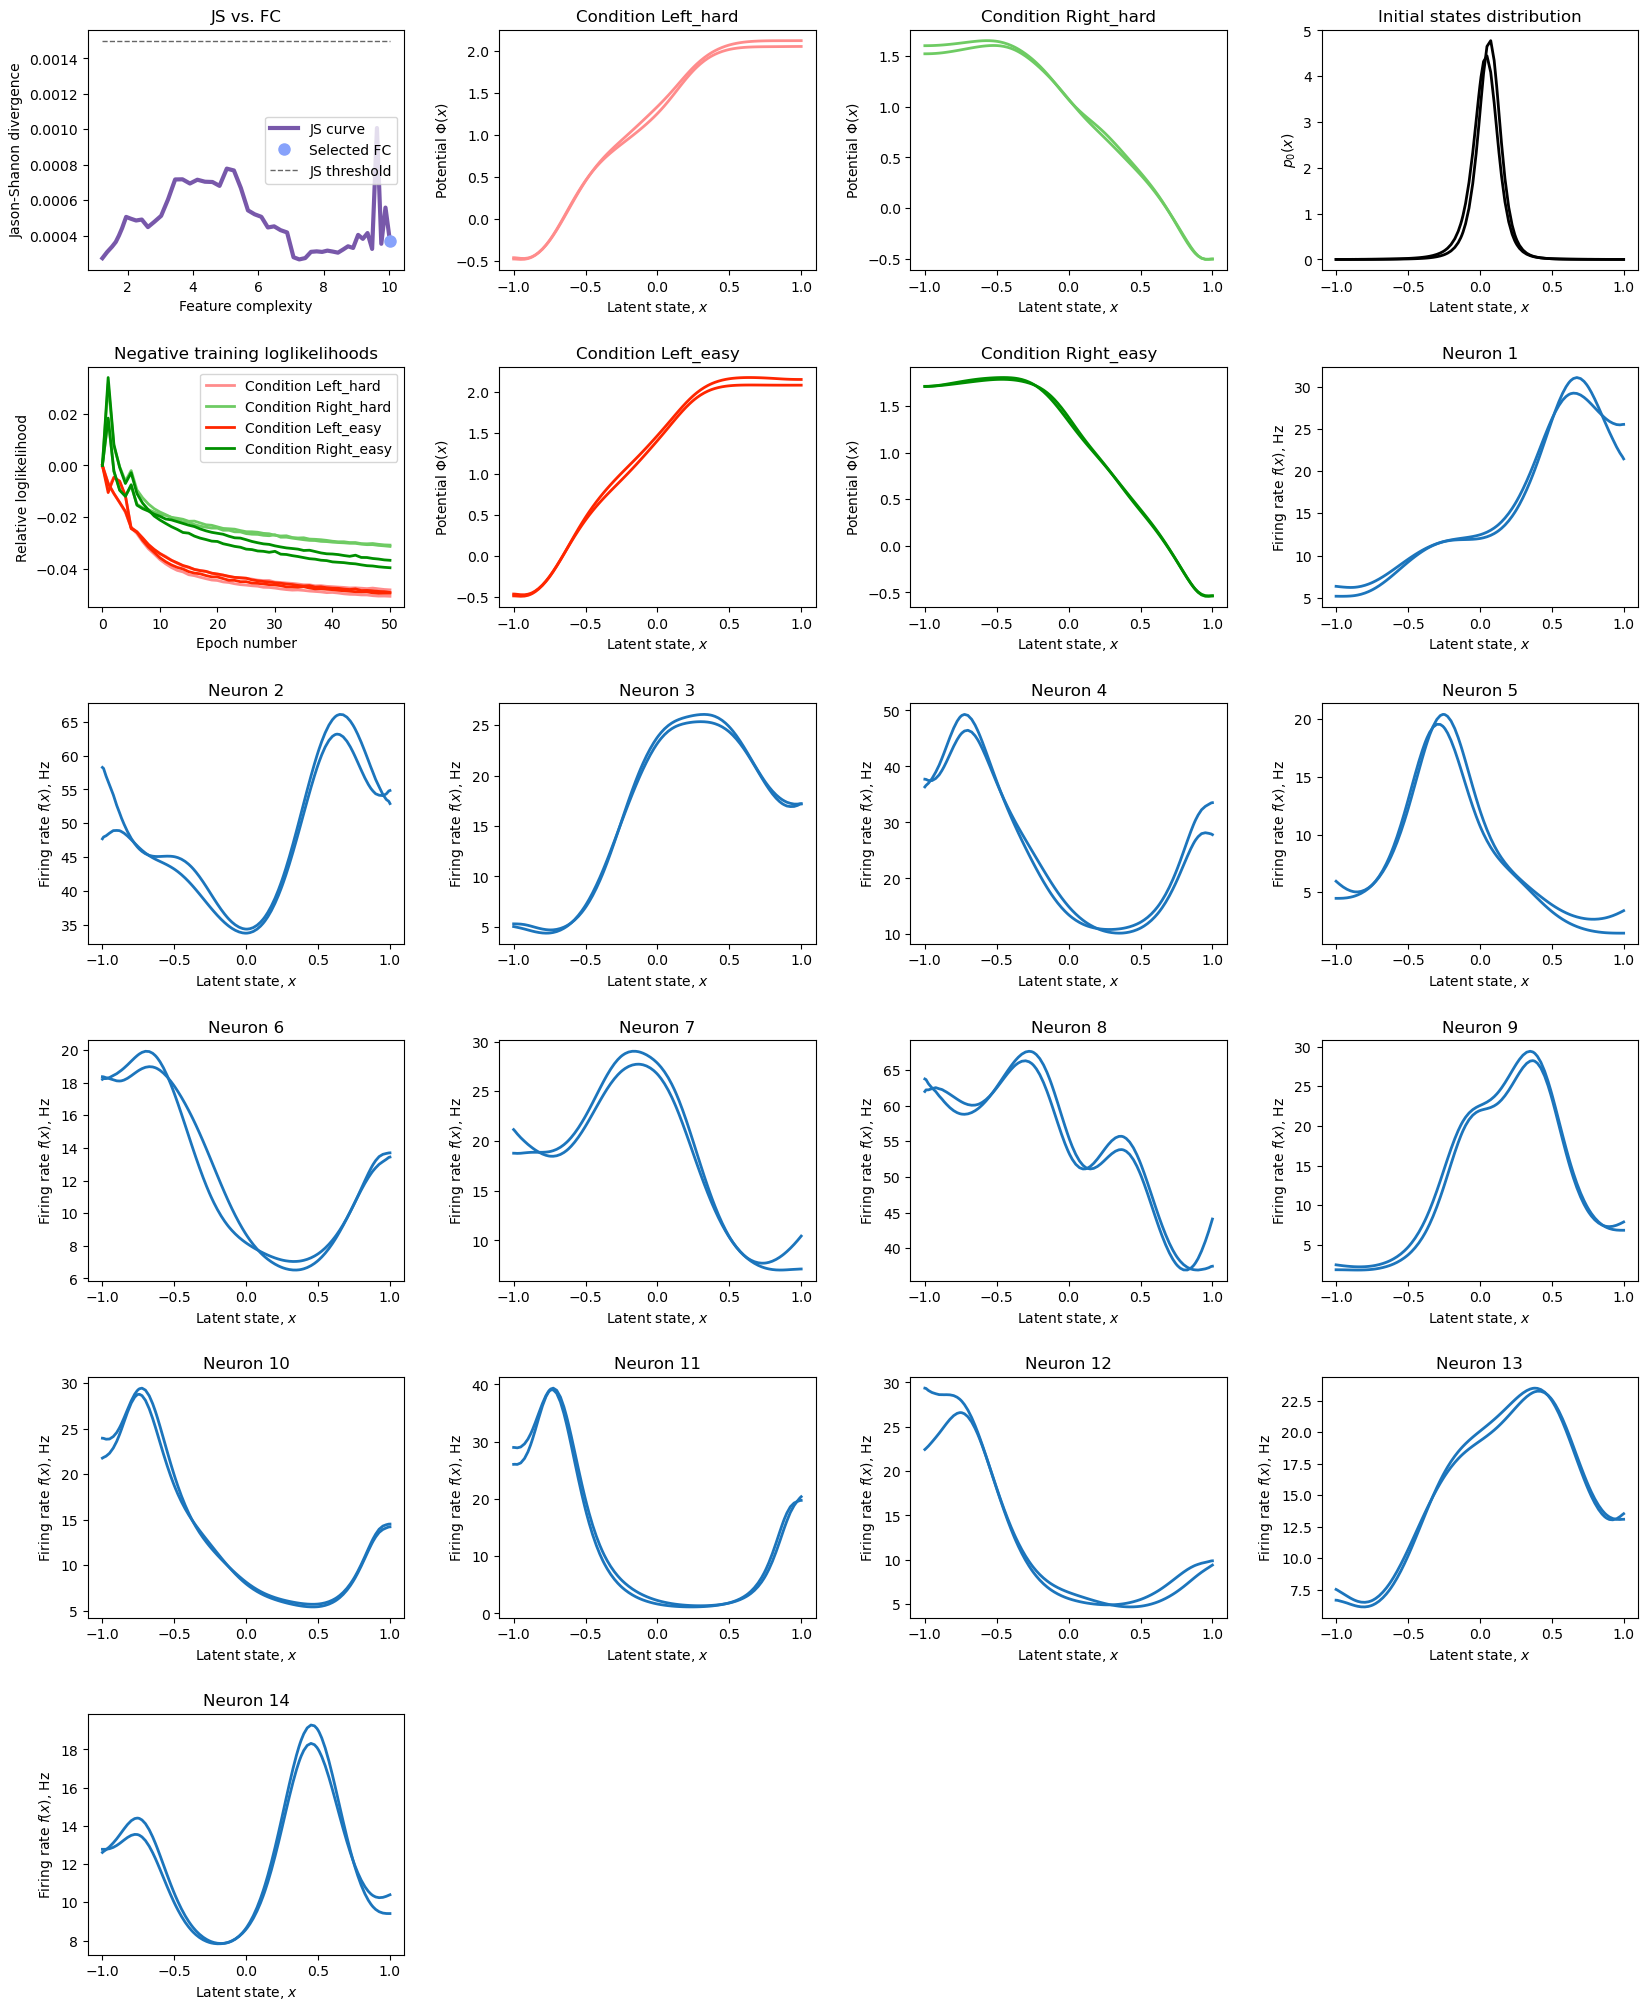

In [5]:
import matplotlib.gridspec as gridspec
  
color_lines = ['#FF8C8C', [0.431, 0.796, 0.388], [1, 0.149, 0], [0, 0.561, 0]]

fig = plt.figure(figsize = (20, 25))
gs = gridspec.GridSpec(6,4, wspace = 0.3, hspace = 0.4)

# Plot JS diveregence vs. FC
ax = plt.subplot(gs[0, 0])
ax.plot(FCs1, JS, linewidth = 3, color = [120/255, 88/255, 170/255], label = 'JS curve')
ax.plot(FCs1[FC_opt_ind], JS[FC_opt_ind], '.', markersize=16, color = '#87A2FB', label = 'Selected FC')
ax.plot(FCs1, JS_thres*np.ones_like(FCs1), '--', linewidth = 1, color = [0.4]*3, label = 'JS threshold')
plt.legend()
plt.xlabel('Feature complexity')
plt.ylabel('Jason-Shanon divergence')
plt.title('JS vs. FC')

# Plot negative relative scaled to start at 0)
# Note that for various reasons logliks may not monotinically decrease for the first few iteration.
ax = plt.subplot(gs[1, 0])
for cond in range(4):
    ll1 = optimization1.results['logliks'][cond]
    ll10 = ll1[0]
    ll1 = (ll1 - ll10) / np.abs(ll10)
    ll2 = optimization2.results['logliks'][cond]
    ll20 = ll2[0]
    ll2 = (ll2 - ll20) / np.abs(ll20)
    iter_nums = np.array(range(ll1.size)).astype('float64')
    ax.plot(iter_nums, ll1, color = color_lines[cond], linewidth = 2, label=f'Condition {list(datasample1.keys())[cond]}')
    ax.plot(iter_nums, ll2,color = color_lines[cond], linewidth = 2)
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Relative loglikelihood')
plt.title('Negative training loglikelihoods')
    
    

opt_ind_1 = min_inds_1[FC_opt_ind]
opt_ind_2 = min_inds_2[FC_opt_ind]
for cond in range(4):
    ax = plt.subplot(gs[cond//2, cond%2+1])
    # Note that original potential needs to be scaled back by D because we use non-conventional form of Langevin and Fokker-Planck equation.
    Phi1 = -np.log(optimization1.results['peq'][opt_ind_1][cond])*optimization1.results['D'][opt_ind_1][0]
    Phi2 = -np.log(optimization2.results['peq'][opt_ind_2][cond])*optimization2.results['D'][opt_ind_2][0]
    plt.plot(init_model.grid.x_d, Phi1, linewidth = 2, color = color_lines[cond])
    plt.plot(init_model.grid.x_d, Phi2[::-1 if invert else 1], linewidth = 2, color = color_lines[cond])
    plt.xlabel('Latent state, $x$')
    plt.ylabel('Potential $\Phi(x)$')
    plt.title(f'Condition {list(datasample1.keys())[cond]}')
    
ax = plt.subplot(gs[0,3])
plt.plot(init_model.grid.x_d, optimization1.results['p0'][opt_ind_1][0], linewidth = 2, color = 'black')
plt.plot(init_model.grid.x_d, optimization2.results['p0'][opt_ind_2][0][::-1 if invert else 1], linewidth = 2, color = 'black')
plt.ylabel('$p_0(x)$')
plt.xlabel('Latent state, $x$')
plt.title('Initial states distribution')


fr_color = [28/255, 117/255, 188/255]
for i in range(14):
    subplot_num = i + 7
    ax = plt.subplot(gs[subplot_num // 4, subplot_num % 4])
    fr1 = optimization1.results['fr'][opt_ind_1][0,...,i]
    fr2 = optimization2.results['fr'][opt_ind_2][0,...,i]
    plt.plot(init_model.grid.x_d, fr1, linewidth = 2, color = fr_color)
    plt.plot(init_model.grid.x_d, fr2[::-1 if invert else 1], linewidth = 2, color = fr_color)
    plt.xlabel('Latent state, $x$')
    plt.ylabel('Firing rate $f(x)$, Hz')
    plt.title(f'Neuron {i+1}')